In [16]:
with open('configs/textdet/dbnet/votecount.py', 'w') as fp:
  fp.write("""_base_ = [
    '_base_dbnet_resnet18_thaidoc.py',
    '../_base_/datasets/votecount.py',
    '../_base_/datasets/thvote.py',
    '../_base_/default_runtime.py',
    '../_base_/schedules/schedule_adam_thaivotelog.py',
]

# dataset settings
thvotecount_textdet_train = _base_.thvc_textdet_train
thvotecount_textdet_train.pipeline=_base_.train_pipeline
thvotecount_textdet_test = _base_.thvote_textdet_test
thvotecount_textdet_test.pipeline = _base_.test_pipeline

train_dataloader = dict(
    batch_size=16,
    num_workers=8,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=True),
    dataset=thvotecount_textdet_train)

val_dataloader = dict(
    batch_size=2,
    num_workers=4,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=thvotecount_textdet_test)

test_dataloader = val_dataloader

max_epochs=30
auto_scale_lr = dict(base_batch_size=100)
train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=10)
param_scheduler = [dict(type='PolyLR', power=0.9, end=max_epochs)]
default_hooks = dict(checkpoint=dict(type='CheckpointHook', interval=5),)
""")

In [17]:
with open('configs/textdet/dbnet/_base_dbnet_resnet18_thaidoc.py', 'w') as fp:
  fp.write("""file_client_args = dict(backend='disk')

model = dict(
    type='DBNet',
    backbone=dict(
        type='mmdet.ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=-1,
        norm_cfg=dict(type='BN', requires_grad=True),
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50'),
        norm_eval=False,
        style='caffe'),
    neck=dict(
        type='FPNC', in_channels=[256, 512, 1024, 2048], lateral_channels=256),
    det_head=dict(
        type='DBHead',
        in_channels=256,
        module_loss=dict(type='DBModuleLoss'),
        postprocessor=dict(type='DBPostprocessor', text_repr_type='quad')),
    data_preprocessor=dict(
        type='TextDetDataPreprocessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_size_divisor=32))

train_pipeline = [
    dict(
        type='LoadImageFromFile',
        file_client_args=file_client_args,
        color_type='color_ignore_orientation'),
    dict(
        type='LoadOCRAnnotations',
        with_polygon=True,
        with_bbox=True,
        with_label=True,
    ),
    dict(
        type='TorchVisionWrapper',
        op='ColorJitter',
        brightness=32.0 / 255,
        saturation=0.5),
    dict(
        type='ImgAugWrapper',
        args=[['Fliplr', 0.5],
              dict(cls='CoarseDropout', p=(0.0005, 0.001), size_percent=0.4),
              dict(cls='Affine', rotate=[-10, 10]),
              dict(cls='GaussianBlur', sigma=(1, 1.6)),
              ['Resize', [0.5, 3.0]],
              dict(cls='CoarseDropout', p=(0.0005, 0.001), size_percent=0.4),
            ]),
    dict(type='RandomCrop', min_side_ratio=0.1),
    dict(type='Resize', scale=(640, 640), keep_ratio=True),
    dict(type='Pad', size=(640, 640)),
    dict(
        type='PackTextDetInputs',
        meta_keys=('img_path', 'ori_shape', 'img_shape'))
]

test_pipeline = [
    dict(
        type='LoadImageFromFile',
        file_client_args=file_client_args,
        color_type='color_ignore_orientation'),
    dict(type='Resize', scale=(1333, 736), keep_ratio=True),
    dict(
        type='LoadOCRAnnotations',
        with_polygon=True,
        with_bbox=True,
        with_label=True,
    ),
    dict(
        type='PackTextDetInputs',
        meta_keys=('img_path', 'ori_shape', 'img_shape', 'scale_factor'))
]
""")

In [13]:
!pip install lanms-nova


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [4]:
from mmocr.api import MMOCRInfer
import cv2
from PIL import Image
import os
import random

In [18]:
ocr = MMOCR(det_ckpt='/workspace/mmocr/work_dirs/votecount/epoch_5.pth',
            det_config='/workspace/mmocr/work_dirs/votecount/votecount.py')

Loads checkpoint by local backend from path: /workspace/mmocr/work_dirs/votecount/epoch_5.pth
05/11 17:34:12 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
05/11 17:34:12 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
05/11 17:34:12 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


In [19]:
image = 'data/det/vl+vc-textdet/imgs'
# ocr.readtext('data/

In [20]:
image

'data/det/vl+vc-textdet/imgs'

In [21]:
dataset_dir = 'data/det/vl+vc-textdet/imgs'
files = os.listdir(dataset_dir)
files = [f for f in files if f.endswith('.jpg') and not f.startswith('.')]

In [22]:
def get_image_path(img_files):
    return random.choice(img_files)

In [43]:
image_file = get_image_path(files)
orinal_image_file = os.path.join(dataset_dir,image_file)
Image.open(orinal_image_file)
ocr.readtext(orinal_image_file, img_out_dir='detshow');

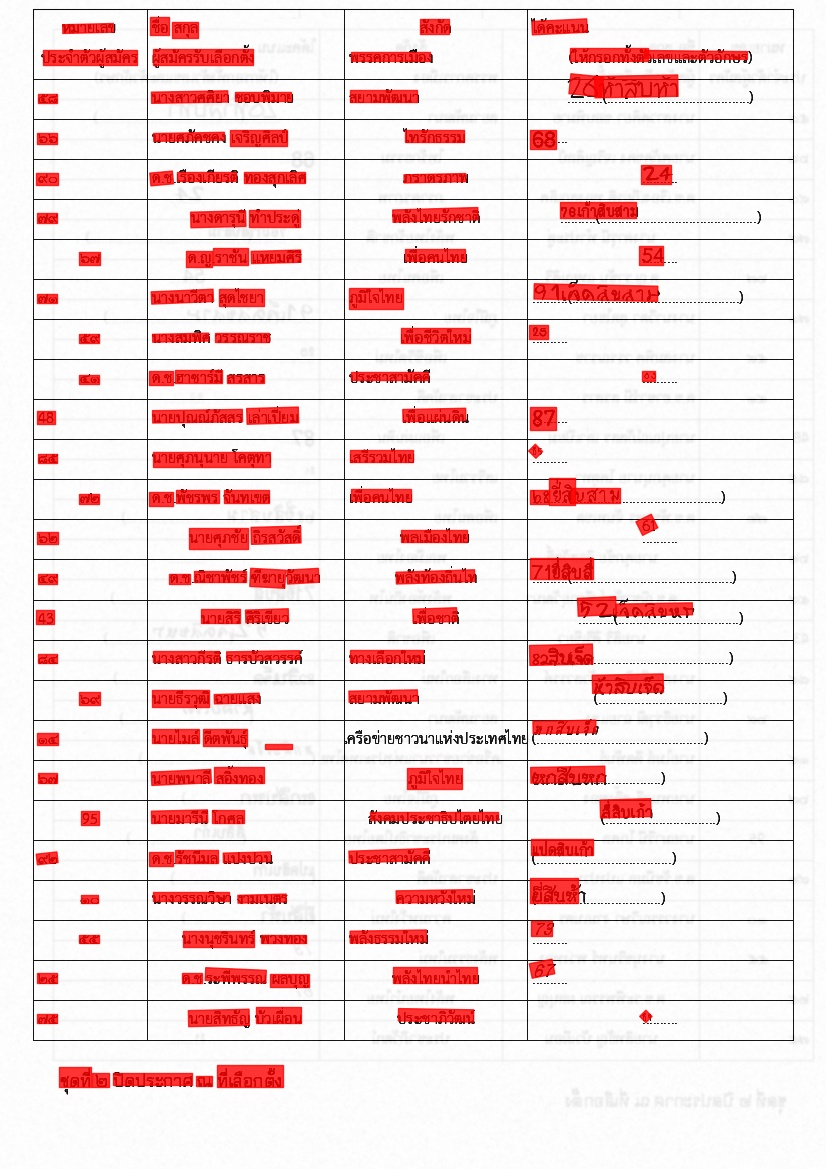

In [44]:
Image.open(os.path.join('detshow', image_file))